In [1]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from MainFunctions import buildmodelFromParams, evalCompleteModel, buildDataFromParams
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
import torch
import gc
import random
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
SEED = 42

c:\Users\micha\Envs\UKSH\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing Params for Best Neural Network Architecture

In [6]:
df = pd.read_csv("neuralnets/netparams.csv")
df = df[df["model"] == "allDataModel"]
df["modelname"] = "allDataModel"
df

,model,datatype,transform,mae,modelSeed,learning_rate,optimizer,blocks,padding,stride,kernel_size,num_epochs,modelname,num_retraining_epochs
1,allDataModel,random_pearson,transform_padding,0.136075,84,0.0193,Adam,4,4,2,7,74,allDataModel,29.0


# Loading Data to use for explaination

In [7]:
datatype = df["datatype"].item()
transform = df["transform"].item()
batch_size = 64
train_loader, val_loader, test_loader, real_train_loader, real_test_loader = buildDataFromParams(datatype, transform, batch_size, percentages=np.array([0.70,0.15,0.15]), percentages_real = np.array([0.6,0.4]), reduceindex=None, seed=SEED , realloc="ECGcutouts/realimgs", oversamp=False, augment=False)
    

# Instantiating model and loading model weights

In [9]:
netparams = df.to_dict('r')[0]
model = buildmodelFromParams(netparams, load=True, seed=SEED)

# Explaination with Integrated Gradients

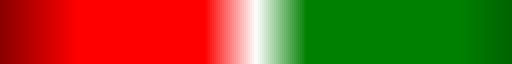

In [4]:
nrows=3
ncols=3
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
                                                  
c = ["darkred","red","red","white", "green","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
cmap

In [11]:
def integratedgradients(model, data, nrows=3, ncols=3, figsize = [12, 10]):
    """Function for executing and visualizing integrated gradients as explained in chapter 9 of the thesis

    Args:
        model (HazelNet): neural network 
        data (DataLoader): data to use for evaluation
        nrows (int, optional): number of rows for visualizing in grid. Defaults to 3.
        ncols (int, optional):  number of columns for visualizing in grid. Defaults to 3.
        figsize (list, optional): size of display figure. Defaults to [12, 10].
    """
    
    integrated_gradients = IntegratedGradients(model)
    # creating list of random indexes for integrated gradients display
    randomidxs = random.sample(range(len(data[2])), nrows*ncols)
    # create figure (fig), and array of axes (ax)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # plot analyzed image on each sub-plot
    for i, axi in enumerate(ax.flat):

        j = randomidxs[i]
        img1, img2, lbl = data[0][j], data[1][j], data[2][j]
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)  

        attributions_ig = integrated_gradients.attribute(img1, n_steps=50, additional_forward_args=img2)

        _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                    np.transpose(img2.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                    method='blended_heat_map',
                                    cmap=cmap,
                                    show_colorbar=True,
                                    sign='all',
                                    outlier_perc=1,            
                                    use_pyplot=False,
                                    plt_fig_axis = (fig,axi)
                                    )

        with torch.no_grad():
            model.eval()
            output = model(img1, img2)


        # write prediction and label as axes' title
        axi.set_title(" Pred: " + str(round(output.item(),2)) + " Lbl: " + str(round(lbl.item(),2)))

        gc.collect()
        torch.clear_autocast_cache(),  torch.cuda.empty_cache()


    plt.tight_layout()
    plt.show()

# Executing Integrated Gradients on ECG Test Holdout

In [ ]:
iterloader = iter(real_test_loader)
data = next(iterloader)

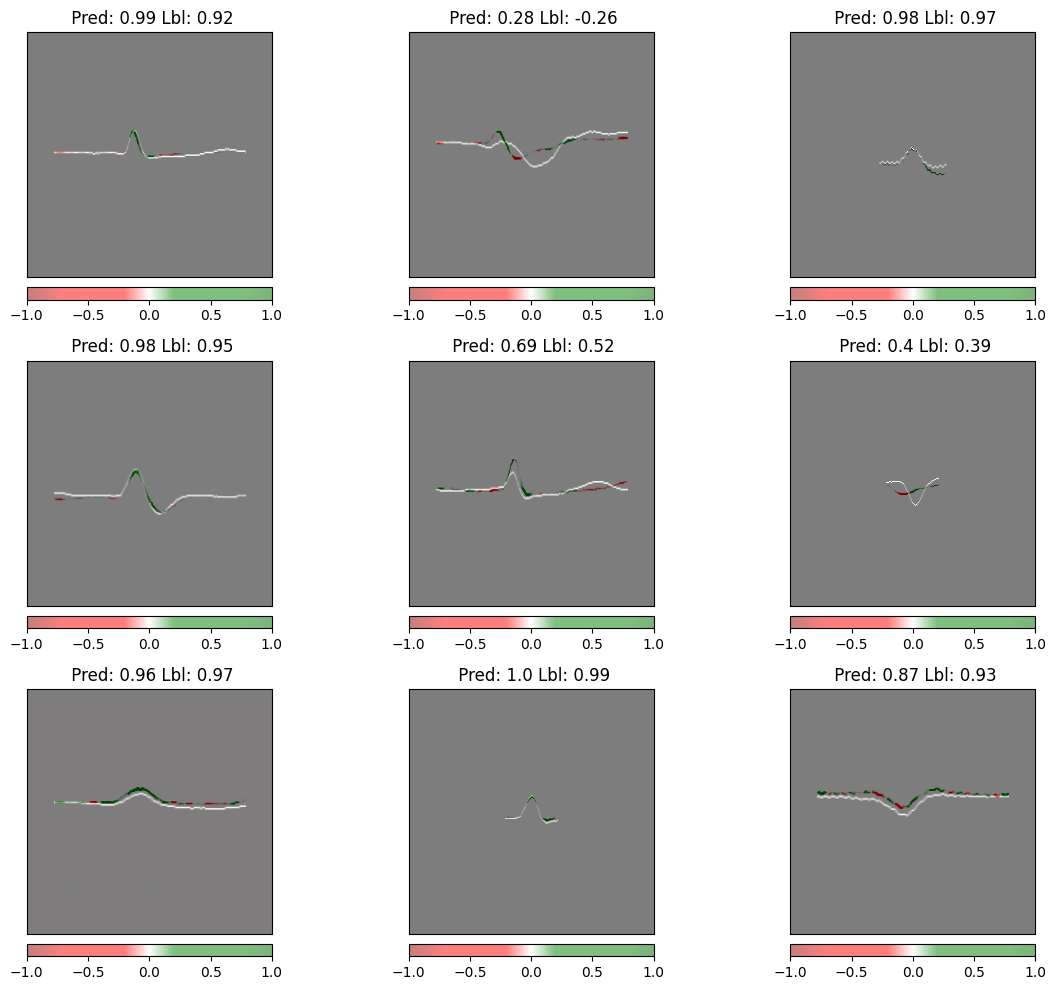

In [12]:
integratedgradients(model=model, data=data)

# Executing same method for AI Data Test Holdout

In [13]:
iterloader = iter(test_loader)
data = next(iterloader)

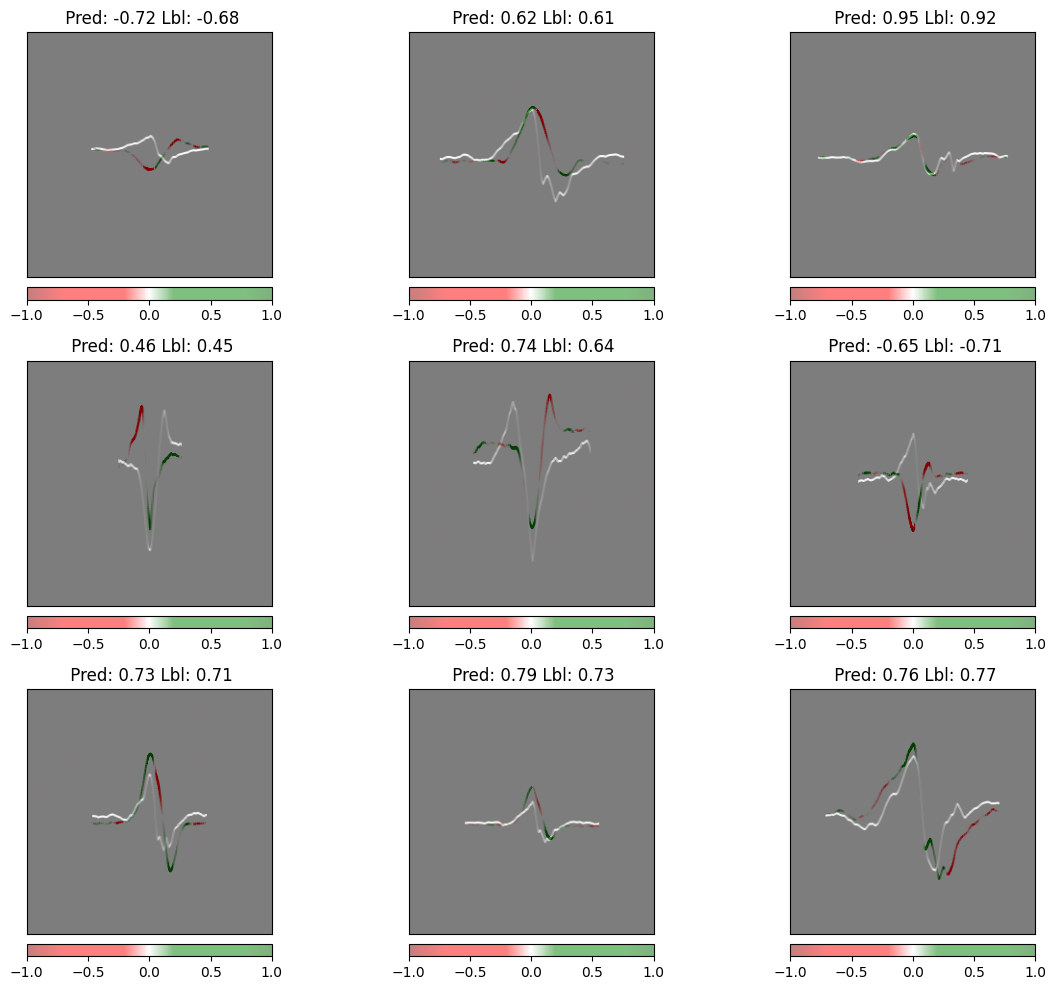

In [14]:
integratedgradients(model=model, data=data)

# Looking at Error Plots
## Calculating errors for MatchEGMAlgorithm
Final algorithm predictions have been presaved and are now loaded from csv file.

In [2]:
df_algo = pd.read_csv("results/algorithmfinalpreds.csv")
df_algo

,target,pred,data
0,0.97,0.971257,real
1,-0.26,0.726067,real
2,0.78,0.956231,real
3,0.99,0.929252,real
4,0.98,0.489463,real
...,...,...,...
1631,1.00,1.000000,ai
1632,1.00,0.999017,ai
1633,1.00,1.000000,ai
1634,1.00,0.996638,ai


## Calculating errors for MatchEGMNetwork

In [10]:
train_loader, val_loader, test_loader, real_train_loader, real_test_loader = buildDataFromParams(datatype, transform, batch_size, percentages=np.array([0.70,0.15,0.15]), percentages_real = np.array([0.6,0.4]), reduceindex=None, seed=SEED , realloc="ECGcutouts/realimgs", oversamp=False, augment=False)
    
total = evalCompleteModel(model, real_test_loader, nbins=20)
df_model = total["df"][["pred", "target"]]
df_model["data"] = "real"

total = evalCompleteModel(model, test_loader, nbins=20)
df_model2 = total["df"][["pred", "target"]]
df_model2["data"] = "ai"

df_model = df_model.append(df_model2)

## Plotting all calculated errors on for ECG Data Holdout

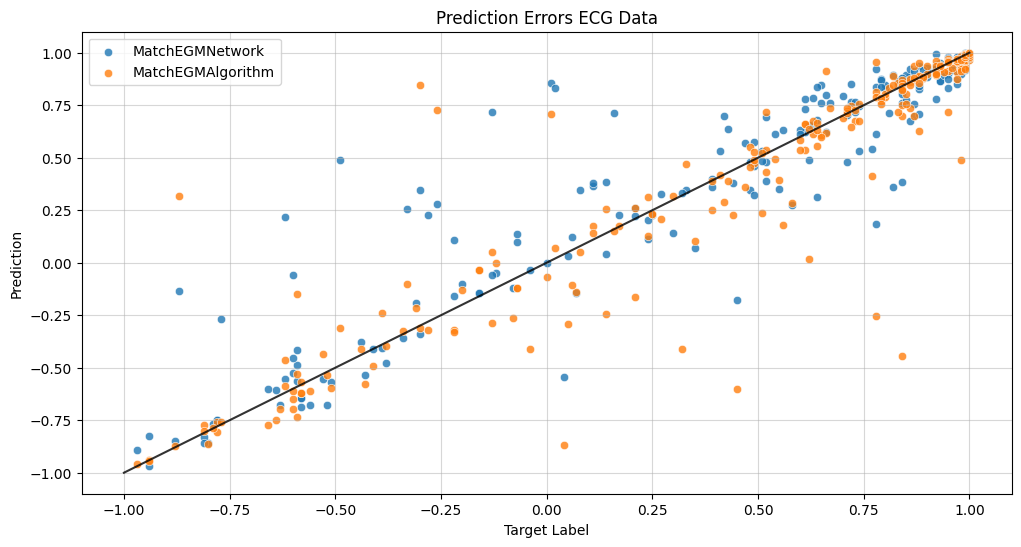

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(df_model[df_model["data"] == "real"], x="target", y="pred", label="MatchEGMNetwork", alpha=0.8)
sns.scatterplot(df_algo[df_algo["data"] == "real"], x="target", y="pred", label="MatchEGMAlgorithm", alpha=0.8)
plt.plot([-1,1],[-1,1], color="black", alpha=0.8)
plt.title("Prediction Errors ECG Data")
plt.xlabel("Target Label")
plt.ylabel("Prediction")
plt.grid(alpha=0.5)

## Now plotting for AI Data Holdout

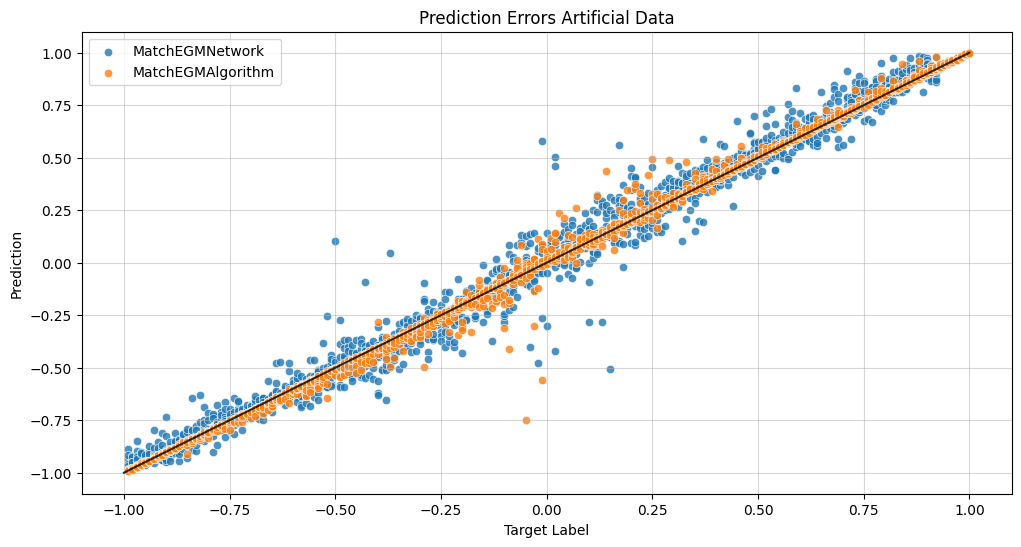

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(df_model[df_model["data"] == "ai"], x="target", y="pred", label="MatchEGMNetwork", alpha=0.8)
sns.scatterplot(df_algo[df_algo["data"] == "ai"], x="target", y="pred", label="MatchEGMAlgorithm", alpha=0.8)
plt.plot([-1,1],[-1,1], color="black", alpha=0.8)
plt.title("Prediction Errors Artificial Data")
plt.xlabel("Target Label")
plt.ylabel("Prediction")
plt.grid(alpha=0.5)